In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

## Modelisation and Data Initialization
The water volume carried by rainfall is represented by $A_t^i=\sum_{n=1}^{N_t^i}U_n^i$ where $N_t$ is a Poisson Process and $U_n$ is the water volume of each rainfall. The water volume in the barrage is represented by $\displaystyle X_t= x_0 + A_t - \int_0^t rX_s  ds$. We suppose that $U_n$ follows a combined exponential distribution.

#### Definition of combined exponential distribution

In [2]:
# N_t^i is a Possion process with parameter lambda_i
# U_t is a random variable with distribution of combination of two exponential random variables

class combination_exponential():
    """
        Combination of two exponential random variables which models the strong and weak rainfalls, the distribution is given by:
        nu(u) = b*delta_1*exp(-delta_1*u)1_{u>0} + (1-b)*delta_2*exp(-delta_2*u)1_{u>0}
    """
    def __init__(self, b, delta_1, delta_2):
        assert b > 0 and b < 1
        assert delta_1 > 0
        assert delta_2 > 0
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2

    def pdf(self, u):
        """
            Probability density function of the combination of two exponential random variables
        """
        if u >= 0:
            return self.b*self.delta_1*np.exp(-self.delta_1*u) + (1-self.b)*self.delta_2*np.exp(-self.delta_2*u)
        else:
            return 0

    def cdf(self, u):
        """
            Cumulative distribution function of the combination of two exponential random variables
        """
        assert u >= 0
        return self.b*(1-np.exp(-self.delta_1*u)) + (1-self.b)*(1-np.exp(-self.delta_2*u))
    
    def rvs(self, size):
        """
            Random variates of the combination of two exponential random variables
        """
        X = np.random.rand(size)
        return np.random.exponential(1/self.delta_1, size=size) * (X < self.b) + np.random.exponential(1/self.delta_2, size=size) * (X >= self.b)

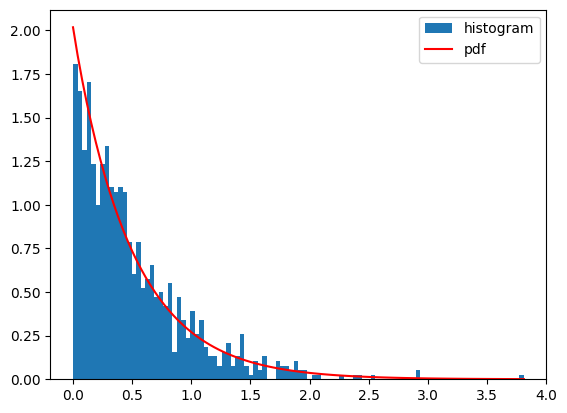

In [53]:
# test for the sample generation
ce = combination_exponential(0.999, 2, 20)
X = ce.rvs(1000)

plt.hist(X, bins=100, density=True, label='histogram')
plt.plot(np.linspace(0, np.max(X), 100), [ce.pdf(x) for x in np.linspace(0, np.max(X), 100)], 'r', label='pdf')
plt.legend()
plt.show()

#### Modelisation of Rainfall and water volume in the barrage

In [3]:
from typing import List

# Rainfall model
class Rainfall():
    """
        Rainfall model A_t = sum_{i=1}^{N_t} U_t^i
        toghether with the model of the volume of the barrage X_t
    """
    def __init__(self, lam, b, delta_1, delta_2, r, t=None, U_t=None):
        self.lam = lam
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2
        self.r = r
        self.ce = combination_exponential(b, delta_1, delta_2)
        # list which represents the Possion process N_t
        if t is None:
            self.t : List = []
        else:
            self.t = t
        # list which represents the quantities of rainfalls at the times t_i
        if U_t is None:
            self.U_t : List = []
        else:
            self.U_t = U_t
    def simulate_for_fixed_T(self, T):
        """
            Simulate the rainfalls on [0, T]
        """
        N_t = sps.poisson.rvs(self.lam*T)
        # no zero at the first
        self.t = np.sort(np.random.uniform(0, T, N_t))
        self.U_t = self.ce.rvs(N_t)

    def reset(self):
        """
            Reset the model
        """
        self.t = []
        self.U_t = []

    def copy(self):
        R = Rainfall(self.lam, self.b, self.delta_1, self.delta_2, self.r, self.t, self.U_t)
        return R
    
    def merge(self, t, U_t):
        """
            Merge two different rainfalls
        """
        merged_t = np.concatenate((self.t, t))
        merged_U_t = np.concatenate((self.U_t, U_t))
        sorted_indices = sorted(range(len(merged_t)), key=lambda k: merged_t[k])
        sorted_t = np.array(sorted(merged_t))
        sorted_U_t = np.array([merged_U_t[i] for i in sorted_indices])
        return Rainfall(self.lam, self.b, self.delta_1, self.delta_2, self.r, sorted_t, sorted_U_t)
    
    def get_volume(self, x0):
        """
            Get the volume of the barrage on [0, T]
            '''math
                X_t = x0 + A_t - int_0^t r*X_s ds
            '''
            return the list of X_t, the volume of the barrage after each rainfalls (local maxima)
        """
        X = [x0]
        for i in range(1, len(self.t)):
            X.append(np.exp(-self.r*(self.t[i]-self.t[i-1]))*X[-1]+self.U_t[i])
        return X
    
    def get_volume_at_t(self, X, t):
        """
            Get the volume of the barrage at time t
        """
        if len(self.t) == 0: # no rain
            return np.exp(-self.r*t)*X[0]    

        if t > self.t[-1]:
            return np.exp(-self.r*(t-self.t[-1]))*X[-1]
        if t < self.t[0]:
            return np.exp(-self.r*t)*X[0]

        # get i such that t_i <= t < t_{i+1}
        i = 1
        while self.t[i] <= t and i < len(self.t)-1:
            i += 1
        return np.exp(-self.r*(t-self.t[i-1]))*X[i-1]


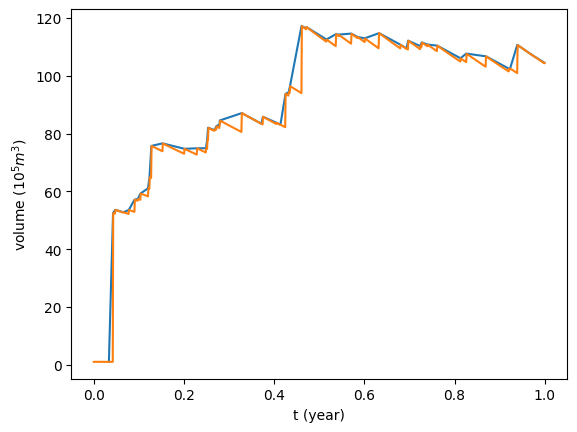

In [9]:
# test for the volume of the barrage
R = Rainfall(70, 0.9, 0.7, 0.07, 1)
R.simulate_for_fixed_T(1)
X = R.get_volume(1)
x = np.linspace(0, 1, 1000)
y = [R.get_volume_at_t(X, t) for t in x]
plt.plot(R.t, X)
plt.plot(x, y)
plt.xlabel('t (year)')
plt.ylabel(r'volume ($10^5 m^3$)')
plt.show()

#### Definition of global parameters

In [4]:
lambda_1 = 70
lambda_2 = 70
delta_1 = 0.07
delta_2 = 0.7
b = 0.1
alpha = 1e-6
T = 1
r_1 = 1
r_2 = 1

#### Determination of the value $x_0$ by numerical method. 
A theorical calculation is presented in the report.

In [11]:
R = Rainfall(lambda_1, b, delta_1, delta_2, r_1)
x_T_values = []
for _ in range(1000):
    R.reset()
    R.simulate_for_fixed_T(100*T)
    X = R.get_volume(5)
    x_T_values.append(R.get_volume_at_t(X, 100*T))
x0 = np.mean(x_T_values)
print(x0)


191.33361398642504


## Study of a single barrage
Nous formulons le problème de rique d'inondation comme suit : nous voulons trouver le seuil $x^\ast$ (soit pour un certain $T$, on prend $X=X_T$, soit pour le volume maximum dans $[0,T]$, on prend $X=\max_{0\le s\le T}X_s$) tel que
$$\mathbb{P}(X>x^\ast)\leq \alpha.$$

#### Approach 1: Naive Monte-Carlo

In [5]:
class naive_MonteCarlo():
    """
        Naive Monte-Carlo algorithm
    """
    def __init__(self, N, x0, T, mode):
        """
            N: number of simulations
            x0: initial volume of the barrage
            T: time horizon
            mode: __T__ for Q1.(a) and __max__ for Q1.(b)
        """
        self.N = N
        self.x0 = x0
        self.T = T
        self.mode = mode

    def get_critical_level(self, lam, b, delta_1, delta_2, r, alpha):
        """
            Obtain the critical level of (1 - alpha) where alpha should not be extremely small
        """
        considered_values = []
        for _ in range(self.N):
            R = Rainfall(lam, b, delta_1, delta_2, r)
            R.simulate_for_fixed_T(self.T)
            X_t = R.get_volume(self.x0)
            if self.mode == "__T__":
                considered_values.append(R.get_volume_at_t(X_t, self.T))
            if self.mode == "__max__":
                considered_values.append(np.max(X_t))

        # c.f. silde 2 page 5
        considered_values = sorted(np.array(considered_values))
        index = int(np.ceil((1-alpha)*self.N))
        L = considered_values[index-1]
        return L

#### Approach 2: Importance Sampling

In [6]:
import scipy.optimize
class importance_sampling():
    """ 
        Importance sampling algorithm for the compound poisson process of parameters (lam, mu)
    """
    def __init__(self, M, x0, T, mode, sigma, beta):
        """
            importance sampling algorithm (Transformation of Esscher), here we use f(x) = sigma*x + beta

            @param M: number of compound Poisson processes
            @param x0: initial volume of the barrage
            @param T: time horizon
            @param mode: __T__ for Q1.(a) and __max__ for Q1.(b)
            @param sigma: parameter of the function f
            @param beta: parameter of the function f
        """
        self.M = M
        self.x0 = x0
        self.T = T
        self.mode = mode
        self.sigma = sigma
        self.beta = beta

    def get_lambda_f_nu_f(self, lam, b, delta_1, delta_2):
        """
            Get the parameters after the change of measure
        """
        lambda_f = lam*np.exp(self.beta)*(b*delta_1/(delta_1-self.sigma)+(1-b)*delta_2/(delta_2-self.sigma))
        b_f = b*delta_1/(delta_1-self.sigma)/(b*delta_1/(delta_1-self.sigma)+(1-b)*delta_2/(delta_2-self.sigma))
        delta_1_f = delta_1-self.sigma
        delta_2_f = delta_2-self.sigma
        return lambda_f, b_f, delta_1_f, delta_2_f


    def get_critical_level(self, lam, b, delta_1, delta_2, r, alpha):
        """
            Run the importance sampling algorithm to estimate E[g(gamma(A_t))], where gamma is a function applied to the trajectory of the compound Poisson process
            here A_t represents the rainfalls at time t
            if mode == __T__, gamma returns the volume at time T, i.e. gamma(A_t) = X_T where X_t is the volume of the barrage
            if mode == __max__, gamma returns the maximum volume on [0, T] i.e. gamma(A_t) = max(X_t)

            '''math
                E[g(gamma(A_t))] = exp((lam_f-lam)*T)1/M*\sum_{m=1}^M g(gamma(A_t^{(m)}))exp(-\sum_{i=1}^{N_T^{(m)}f(U_i^{(m)}))
            '''
            where A_t^{(m)} are M compound Poisson processes with parameters (lam_f, mu_f)

            If we want to estimate the (1-alpha) quantile of the distribution of gamma(A_t), we can use g = 1_{gamma(A_t) > L}
            i.e. we want to find L such that E[1_{gamma(A_t) > L}] = alpha

            An estimator of L can be obtained by sorting the values of gamma(A_t^{(m)})exp(-\sum_{i=1}^{N_T^{(m)}f(U_i^{(m)})) and taking the alpha*exp(-(lam_f-lam)*T)th value.

        """
        lambda_f, b_f, delta_1_f, delta_2_f = self.get_lambda_f_nu_f(lam, b, delta_1, delta_2)
        values_Xt = []
        values = []
        for _ in range(self.M):
            R = Rainfall(lambda_f, b_f, delta_1_f, delta_2_f, r)
            R.simulate_for_fixed_T(self.T)
            X_t = R.get_volume(self.x0)

            # apply the fuction gamma
            if self.mode == "__T__":
                values_Xt.append(np.exp(-self.sigma*np.sum(R.U_t)-self.beta*len(R.U_t)))
                values.append(R.get_volume_at_t(X_t, self.T))
            if self.mode == "__max__":
                values_Xt.append(np.exp(-self.sigma*np.sum(R.U_t)-self.beta*len(R.U_t)))
                values.append(np.max(X_t))
            
        alpha_f = alpha*np.exp(-(lambda_f-lam)*self.T)
        indices = np.argsort(values)
        sorted_values_Xt = [values_Xt[i] for i in indices][::-1]
        idx = 0
        sum_values = 0
        while sum_values < alpha_f*self.M and idx < self.M:
            sum_values += sorted_values_Xt[idx]
            idx += 1
        L = values[indices[-idx]]
        return L
    
# calculate the coefficients of the importance sampling
'''
    We want to find sigma such that
        \sigma \phi'(sigma) - \phi(sigma) = \log(\alpha)
    where \phi(s) = \lambda T (M_\nu(s) - 1) and M_\nu(s) = b\delta_1/(\delta_1-s)+(1-b)\delta_2/(\delta_2-s)
'''
def M_nu(s, b, delta_1, delta_2):
    """
        Get the M_nu function
    """
    return b*delta_1/(delta_1-s)+(1-b)*delta_2/(delta_2-s)
def dM_nu(s, b, delta_1, delta_2):
    """
        Get the derivative of M_nu function
    """
    return b*delta_1/(delta_1-s)**2+(1-b)*delta_2/(delta_2-s)**2

def get_importance_sampling_coef(alpha, lam, b, delta_1, delta_2, T):
    """
        Get the importance sampling coefficient sigma
    """
    def equation(s):
        return lam*T*dM_nu(s, b, delta_1, delta_2)*s + np.log(alpha) - lam*T*(M_nu(s, b, delta_1, delta_2)-1)
    
    s = scipy.optimize.brentq(equation, 0, min(delta_1, delta_2)-1e-6)
    return s

#### Approach 3: Last Particle Algorithm

In [7]:
class last_particle():
    """
        Last particle algorithm    
    """
    def __init__(self, N, M, x0, T, mode):
        """
            @param N: number of particles
            @param M: number of iterations: after M iterations, the new rainfall is considered independent from the original one
            @param x0: initial volume of the barrage
            @param T: time horizon
            @param mode: __T__ for Q1.(a) and __max__ for Q1.(b)
        """
        self.N = N
        self.M = M
        self.x0 = x0
        self.T = T
        self.mode = mode

    def get_new_rainfall(self, R, L, p=0.5, q=0.9):
        """
            Obtain a new rainfall > L almost independent from the original one by M iterations

            @param R: original rainfall
            @param L: critical level
            @param p: proportion of the preserved jump points
            @param q: proportion of the preserved values of the jump points

            @return R_start: new rainfall
            @return accept_rate: acceptance rate
        """
        # idea c.f. TP 5
        R_start = R.copy()
        accept = 0
        for _ in range(self.M):
            Unif = np.array(np.random.uniform(0, 1, len(R_start.t)))
            retained_indices = np.argwhere(Unif <= p)
            retained_indices = retained_indices.ravel()
            t_p = R_start.t[retained_indices]
            U_t_initial_p = R_start.U_t[retained_indices]
            R_other = Rainfall(R.lam*(1-p), R.b, R.delta_1, R.delta_2, R.r)
            R_other.simulate_for_fixed_T(self.T)
            
            # (×) Mention that for those U_t preserved, it is necessary to choose a new one with P(U_t, ·), where P is nu-revertible, c.f. silde 3 page 28 
            # (×) Use Metropolis-Hastings algorithm here, with q = standard gaussian, c.f. silde 2 page 22

            # For those U_t preserved, obtain a new one with original value in proportion q and new value given by nu in proportion (1-q), c.f. 26/04 visio online
            nu = combination_exponential(R.b, R.delta_1, R.delta_2)
            q_variation = nu.rvs(len(U_t_initial_p))
            U_t_p = q_variation*(1-q) + U_t_initial_p*q

            R_next = R_other.merge(t_p, U_t_p)
            R_next.lam = R.lam
            X_t_next = R_next.get_volume(self.x0)
            if self.mode == "__T__":
                if R_next.get_volume_at_t(X_t_next, self.T) > L:
                    accept += 1
                    R_start = R_next
            if self.mode == "__max__":
                if np.max(X_t_next) > L:
                    accept += 1
                    R_start = R_next
        return R_start, accept/self.M

    def get_new_rainfall_at_least_M(self, R, L, p=0.4, q=0.9):
        """
            Obtain a new rainfall > L almost independent from the original one, we demand that there are at least M/2 acceptances

            @return R_start: new rainfall
        """
        # idea c.f. TP 5
        R_start = R.copy()
        accept = 0
        i = 0
        while (i <= self.M or accept <= int(self.M/2)):
            Unif = np.array(np.random.uniform(0, 1, len(R_start.t)))
            retained_indices = np.argwhere(Unif <= p)
            retained_indices = retained_indices.ravel()
            t_p = R_start.t[retained_indices]
            U_t_initial_p = R_start.U_t[retained_indices]
            R_other = Rainfall(R.lam*(1-p), R.b, R.delta_1, R.delta_2, R.r)
            R_other.simulate_for_fixed_T(self.T)

            # For those U_t preserved, obtain a new one with original value in proportion q and new value given by nu in proportion (1-q), c.f. 26/04 visio online
            nu = combination_exponential(R.b, R.delta_1, R.delta_2)
            q_variation = nu.rvs(len(U_t_initial_p))
            U_t_p = q_variation*(1-q) + U_t_initial_p*q

            R_next = R_other.merge(t_p, U_t_p)
            R_next.lam = R.lam
            X_t_next = R_next.get_volume(self.x0)
            if self.mode == "__T__":
                if R_next.get_volume_at_t(X_t_next, self.T) > L:
                    accept += 1
                    R_start = R_next
            if self.mode == "__max__":
                if np.max(X_t_next) > L:
                    accept += 1
                    R_start = R_next
            i += 1
        return R_start

    def get_critical_level_and_distribution(self, lam, b, delta_1, delta_2, r, alpha, p=0.5, q=0.9, return_accept_rate=False, return_critical_X_t=False):
        """
            Obtain the critical level of (1 - alpha) and overtaking distribution of this level with M fixed

            @return L: critical level
            @return critical_X_t (List) : overtaking distribution of L
            @return accept_rate (List): acceptance rate 
        """
        A_t = []
        critical_X_t = []
        for _ in range(self.N):
            R_initial = Rainfall(lam, b, delta_1, delta_2, r)
            R_initial.simulate_for_fixed_T(self.T)
            A_t.append(R_initial)
            X_t_initial = R_initial.get_volume(self.x0)
            if self.mode == "__T__":
                critical_X_t.append(R_initial.get_volume_at_t(X_t_initial, self.T))
            if self.mode == "__max__":
                critical_X_t.append(np.max(X_t_initial))
        L = np.min(critical_X_t)

        # c.f. silde 4 part 1 page 13
        stop_index = int(np.ceil(np.log(alpha) / np.log(1-1/self.N)))
        accept_rate = []
        for k in range(stop_index):
            reached_indices = np.argwhere(critical_X_t == L)
            reached_indices = reached_indices.ravel()
            outer_indices = np.setdiff1d(np.arange(self.N), reached_indices)
            for i in reached_indices:
                j = np.random.choice(outer_indices)
                R_new, accept_rate_R = self.get_new_rainfall(A_t[j], L, p=p, q=q)
                accept_rate.append(accept_rate_R)
                A_t[i] = R_new
                X_t_new = R_new.get_volume(self.x0)
                if self.mode == "__T__":
                    critical_X_t[i] = R_new.get_volume_at_t(X_t_new, self.T)
                if self.mode == "__max__":
                    critical_X_t[i] = np.max(X_t_new)
            L = np.min(critical_X_t)

        if return_accept_rate and return_critical_X_t:
            return L, critical_X_t, accept_rate
        if return_accept_rate:
            return L, accept_rate
        if return_critical_X_t:
            return L, critical_X_t
        return L
    
    def get_critical_level_and_distribution_with_variant_M(self, lam, b, delta_1, delta_2, r, alpha, p=0.5, q=0.9, return_accept_rate=False, return_critical_X_t=False):
        """
            Obtain the critical level of (1 - alpha) and overtaking distribution of this level with M increasing
            M increases linearly with the rate of 1 + k/(stop_index*alpha*1000), where k is the current iteration
        """
        A_t = []
        critical_X_t = []
        for _ in range(self.N):
            R_initial = Rainfall(lam, b, delta_1, delta_2, r)
            R_initial.simulate_for_fixed_T(self.T)
            A_t.append(R_initial)
            X_t_initial = R_initial.get_volume(self.x0)
            if self.mode == "__T__":
                critical_X_t.append(R_initial.get_volume_at_t(X_t_initial, self.T))
            if self.mode == "__max__":
                critical_X_t.append(np.max(X_t_initial))
        L = np.min(critical_X_t)

        # c.f. silde 4 part 1 page 13
        stop_index = int(np.ceil(np.log(alpha) / np.log(1-1/self.N)))
        accept_rate = []
        M = self.M
        for k in range(stop_index):
            reached_indices = np.argwhere(critical_X_t == L)
            reached_indices = reached_indices.ravel()
            outer_indices = np.setdiff1d(np.arange(self.N), reached_indices)
            for i in reached_indices:
                j = np.random.choice(outer_indices)
                self.M = int(M*(1+(k+1)/(stop_index*alpha*1000))) # Here M increases linearly
                R_new, accept_rate_R = self.get_new_rainfall(A_t[j], L, p=p, q=q)
                accept_rate.append(accept_rate_R)
                A_t[i] = R_new
                X_t_new = R_new.get_volume(self.x0)
                if self.mode == "__T__":
                    critical_X_t[i] = R_new.get_volume_at_t(X_t_new, self.T)
                if self.mode == "__max__":
                    critical_X_t[i] = np.max(X_t_new)
            L = np.min(critical_X_t)
        self.M = M
        if return_accept_rate and return_critical_X_t:
            return L, critical_X_t, accept_rate
        if return_accept_rate:
            return L, accept_rate
        if return_critical_X_t:
            return L, critical_X_t
        return L
    
    def get_critical_level_and_distribution_at_least_M(self, lam, b, delta_1, delta_2, r, alpha, p=0.4, q=0.9, return_critical_X_t=False):
        """
            Obtain the critical level of (1 - alpha) and overtaking distribution of this level which demands that there are at least M/2 acceptances 
        """
        A_t = []
        critical_X_t = []
        for _ in range(self.N):
            R_initial = Rainfall(lam, b, delta_1, delta_2, r)
            R_initial.simulate_for_fixed_T(self.T)
            A_t.append(R_initial)
            X_t_initial = R_initial.get_volume(self.x0)
            if self.mode == "__T__":
                critical_X_t.append(R_initial.get_volume_at_t(X_t_initial, self.T))
            if self.mode == "__max__":
                critical_X_t.append(np.max(X_t_initial))
        L = np.min(critical_X_t)

        # c.f. silde 4 part 1 page 13
        stop_index = int(np.ceil(np.log(alpha) / np.log(1-1/self.N)))
        for k in range(stop_index):
            reached_indices = np.argwhere(critical_X_t == L)
            reached_indices = reached_indices.ravel()
            outer_indices = np.setdiff1d(np.arange(self.N), reached_indices)
            for i in reached_indices:
                j = np.random.choice(outer_indices)
                R_new = self.get_new_rainfall_at_least_M(A_t[j], L, p=p, q=q) # Here we demand at least M/2 acceptances
                A_t[i] = R_new
                X_t_new = R_new.get_volume(self.x0)
                if self.mode == "__T__":
                    critical_X_t[i] = R_new.get_volume_at_t(X_t_new, self.T)
                if self.mode == "__max__":
                    critical_X_t[i] = np.max(X_t_new)
            L = np.min(critical_X_t)
        if return_critical_X_t:
            return L, critical_X_t
        return L

## Numerical Experiment for $\alpha=0.01$

In [11]:
N = 1000
M = 30
x_0 = 190

In [24]:
# use naive Monte-Carlo algorithm
alg_naive = naive_MonteCarlo(N*10, x_0, T, "__max__")

# use importance sampling algorithm
sigma = get_importance_sampling_coef(1e-2, lambda_1, b, delta_1, delta_2, T)
alg_importance = importance_sampling(N*10, x_0, T, "__max__", sigma, 0)

# use last particle algorithm
alg_last_particle = last_particle(N, M, x_0, T, "__max__")

# get the critical level
L_naive = [alg_naive.get_critical_level(lambda_1, b, delta_1, delta_2, r_1, 1e-2) for _ in range(10)]
L_importance = [alg_importance.get_critical_level(lambda_1, b, delta_1, delta_2, r_1, 1e-2) for _ in range(10)]
L_last_particle = [alg_last_particle.get_critical_level_and_distribution_with_variant_M(lambda_1, b, delta_1, delta_2, r_1, 1e-2, p=0.25) for _ in range(10)]

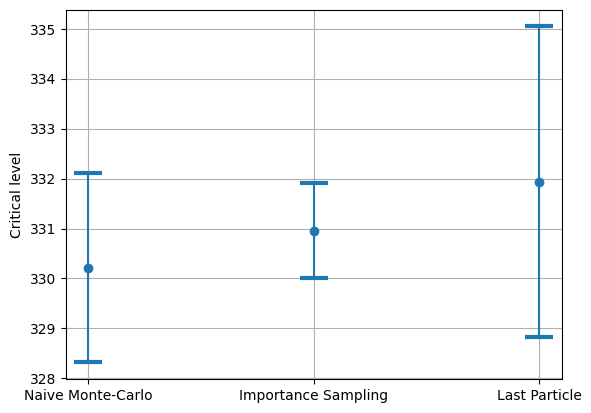

In [30]:
x_naif = np.array(L_naive)
x_importance = np.array(L_importance)
x_last = np.array(L_last_particle)

# calculate the mean and the error
categories = ['Naive Monte-Carlo', 'Importance Sampling', 'Last Particle']
values = [np.mean(x_naif), np.mean(x_importance), np.mean(x_last)]
## use max-min as the error
errors = [(np.max(x_naif)-np.min(x_naif))/2, (np.max(x_importance)-np.min(x_importance))/2, (np.max(x_last)-np.min(x_last))/2]

# visualize the results
plt.figure()
plt.errorbar(categories, values, yerr=errors, fmt='o', capsize=10, capthick=3)
plt.ylabel('Critical level')
plt.grid(True)
plt.show()

#### Show the distribution after the critical level

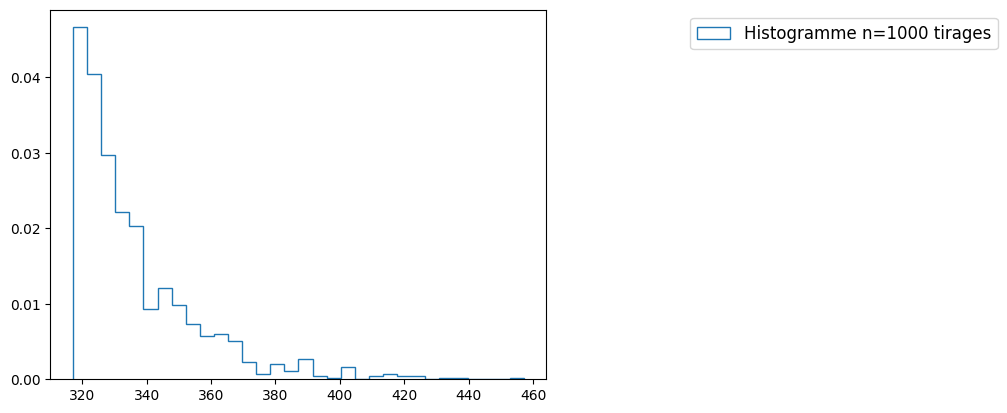

In [51]:
alg_max = last_particle(N, M, x_0, T, "__max__")
L, values = alg_max.get_critical_level_and_distribution_with_variant_M(lambda_1, b, delta_1, delta_2, r_1, 0.01, return_critical_X_t=True)
plt.hist(values, bins="auto", density=True, histtype="step", label="Histogramme n=%1.0f tirages" %N)
plt.legend(fontsize=12, loc=9, bbox_to_anchor=(1.6, 1.0), ncol=1)
plt.show()

## Numerical Experiment for $\alpha=10^{-6}$

In [9]:
# use naive Monte-Carlo algorithm
alg_naive = naive_MonteCarlo(N*100, x_0, T, "__max__")

# use importance sampling algorithm
sigma = get_importance_sampling_coef(alpha, lambda_1, b, delta_1, delta_2, T)
alg_importance = importance_sampling(N*100, x_0, T, "__max__", sigma, 0)

# use last particle algorithm
# very slow, won't show here, but we run the code in the cluster of CPHT
# M = 30, p = 0.4, q = 0.9, use get_critical_level_and_distribution_at_least_M

# get the critical level
L_naive = [alg_naive.get_critical_level(lambda_1, b, delta_1, delta_2, r_1, alpha) for _ in range(10)]
L_importance = [alg_importance.get_critical_level(lambda_1, b, delta_1, delta_2, r_1, alpha) for _ in range(10)]
L_last_particle = [519.6528312371129, 522.9313629060968, 514.8146891768554, 523.5562194211619, 523.6603302590826, 523.5970719665972, 522.70723810166, 524.5718412202705, 520.8673510044459, 523.1283797399925]

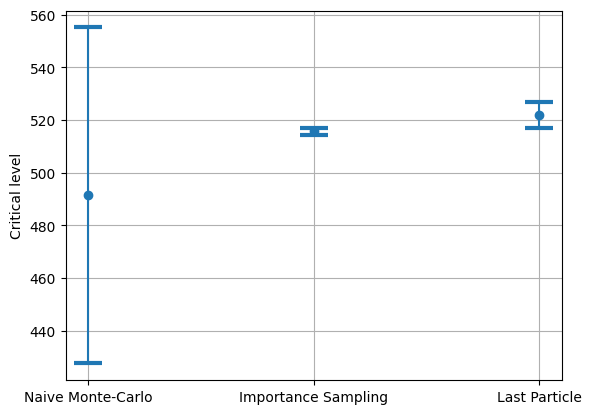

In [10]:
x_naif = np.array(L_naive)
x_importance = np.array(L_importance)
x_last = np.array(L_last_particle)

# calculate the mean and the error
categories = ['Naive Monte-Carlo', 'Importance Sampling', 'Last Particle']
values = [np.mean(x_naif), np.mean(x_importance), np.mean(x_last)]
## use max-min as the error
errors = [(np.max(x_naif)-np.min(x_naif))/2, (np.max(x_importance)-np.min(x_importance))/2, (np.max(x_last)-np.min(x_last))/2]

# visualize the results
plt.figure()
plt.errorbar(categories, values, yerr=errors, fmt='o', capsize=10, capthick=3)
plt.ylabel('Critical level')
plt.grid(True)
plt.show()

## Studies of the influences of $p$ and $q$ in the last particle algorithm

We will choose $\alpha=0.01$ to ensure that the naive Monte Carlo algorithm works correctly. We condsider first the parametre $p\in[0,1]$ and visualise the change from the change in $p$.

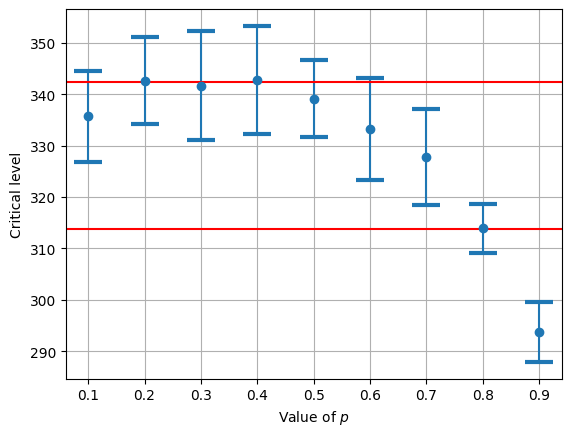

In [24]:
alg_max_last = last_particle(100, M, x_0, T, "__max__")
categories = []
values = []
errors = []
for p in range(1, 10):
    L_last_particle = [alg_max_last.get_critical_level_and_distribution_at_least_M(lambda_1, b, delta_1, delta_2, r_1, 1e-2, p=p/10) for _ in range(10)]
    x_last = np.array(L_last_particle)
    categories.append(p/10)
    values.append(np.mean(x_last))
    errors.append((np.max(x_last)-np.min(x_last))/2)
plt.figure()
plt.errorbar(categories, values, yerr=errors, fmt='o', capsize=10, capthick=3)
alg_max_naive = naive_MonteCarlo(N, x_0, T, "__max__")
L_naive = [alg_max_naive.get_critical_level(lambda_1, b, delta_1, delta_2, r_1, 0.01) for _ in range(10)]
x_naif = np.array(L_naive)
plt.axhline(y=np.max(x_naif), color='r', linestyle='-')
plt.axhline(y=np.min(x_naif), color='r', linestyle='-')
plt.xlabel(r'Value of $p$')
plt.ylabel('Critical level')
plt.grid(True)
plt.show()

Here we show that acceptation rates can be zero even $\alpha$ is not extremely small.

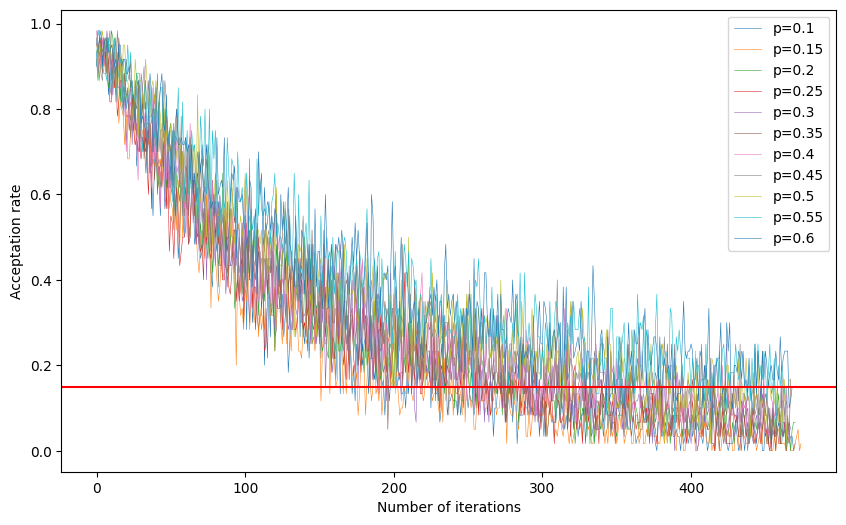

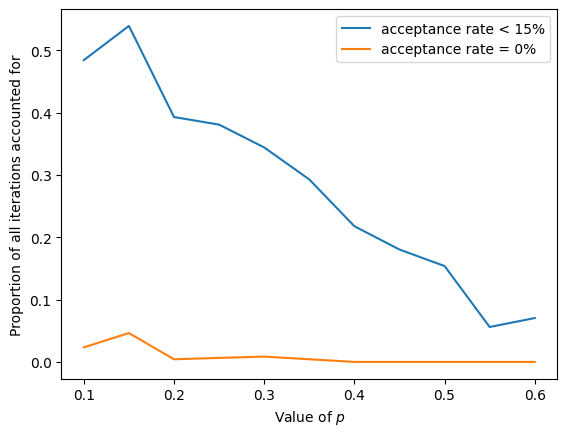

In [21]:
alg_max = last_particle(100, M*2, x_0, T, "__max__")
plt.figure(figsize=(10, 6))
low_accept_rate = []
zero_rate = []
for p in range(2, 13):
    L, accept_rate = alg_max.get_critical_level_and_distribution(lambda_1, b, delta_1, delta_2, r_1, 0.01, p=p/20, return_accept_rate=True)
    plt.plot(accept_rate, linewidth=0.4, linestyle='-', label=f'p={p/20}')
    accept_rate = np.array(accept_rate)
    low_accept_rate.append(np.sum(accept_rate<0.15)/len(accept_rate))
    zero_rate.append(np.sum(accept_rate==0)/len(accept_rate))
plt.axhline(y=0.15, color='r', linestyle='-')
plt.ylabel('Acceptation rate')
plt.xlabel('Number of iterations')
plt.legend(loc='best')
plt.show()

p_index = np.arange(0.1, 0.65, 0.05)
plt.plot(p_index, low_accept_rate, label="acceptance rate < 15%")
plt.plot(p_index, zero_rate, label="acceptance rate = 0%")
plt.xlabel(r'Value of $p$')
plt.ylabel('Proportion of all iterations accounted for')
plt.legend(loc='best')
plt.show()

We consider now $q\in[0,1]$.

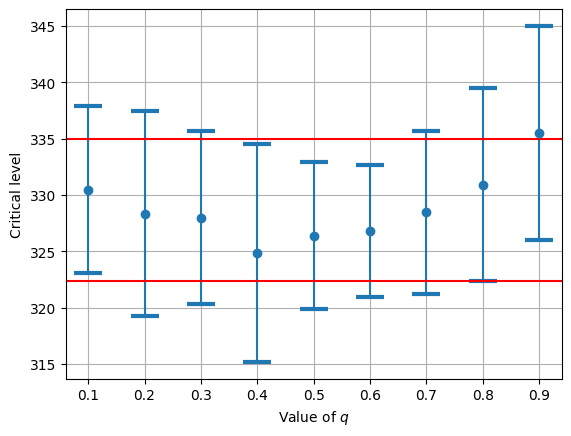

In [25]:
alg_max_last = last_particle(100, M, x_0, T, "__max__")
categories = []
values = []
errors = []
for q in range(1, 10):
    L_last_particle = [alg_max_last.get_critical_level_and_distribution_at_least_M(lambda_1, b, delta_1, delta_2, r_1, 1e-2, q=q/10) for _ in range(10)]
    x_last = np.array(L_last_particle)
    categories.append(q/10)
    values.append(np.mean(x_last))
    errors.append((np.max(x_last)-np.min(x_last))/2)
plt.figure()
plt.errorbar(categories, values, yerr=errors, fmt='o', capsize=10, capthick=3)
alg_max_naive = naive_MonteCarlo(N, x_0, T, "__max__")
L_naive = [alg_max_naive.get_critical_level(lambda_1, b, delta_1, delta_2, r_1, 0.01) for _ in range(10)]
x_naif = np.array(L_naive)
plt.axhline(y=np.max(x_naif), color='r', linestyle='-')
plt.axhline(y=np.min(x_naif), color='r', linestyle='-')
plt.xlabel(r'Value of $q$')
plt.ylabel('Critical level')
plt.grid(True)
plt.show()